In [1]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd

All_Shipments_1 = dataiku.Dataset("All_Shipments_1")
All_Shipments_1_df = All_Shipments_1.get_dataframe()
ship = All_Shipments_1_df.copy() 

j = dataiku.Dataset("InView___Updated_List_of_5_Mil_Generics_for_Fcst_Testing__1_18_23_")
j_df = j.get_dataframe()[['Generic','Plnt','4 Month Trend']]
j_df['Plant-Generic'] = j_df['Plnt'].astype(str)+'-'+j_df['Generic'].astype(str)
j_df = j_df.drop(columns=['Plnt','Generic'])

/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/pandas/io/parsers.py:2037: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self._reader.read(nrows)
/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: DtypeWarning: Columns (42,43,57,71,80) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. 

In [47]:
start = '2019-01-01'
end = '2022-12-01'
df = ship[ship['In/External Shipments']=='External SO'][ship['Pole']=='NAM']\
    .groupby(['Actual GI Date','Plant','Generic'])['KG'].agg(['count', 'sum']).reset_index() 
df = df[df['Plant'].isin([3803, 3809, 3811, 3833, 3835, 3841])]
df = df.rename(columns={'Actual GI Date':'Date'})
df['Date'] = pd.to_datetime(df['Date']);df = df[df['Date']>=pd.to_datetime(start)]
df['Year'] = df['Date'].dt.year; df['Month'] = df['Date'].dt.month

df = df.groupby(['Plant','Generic','Year','Month'])[['sum','count']].sum().reset_index()
df['ds'] = pd.to_datetime(df['Year'].astype(str)+'-'+df['Month'].astype(str)+'-1')  
df = df[df['ds']<=pd.to_datetime(end)]    
df['Plant-Generic'] = df['Plant'].astype(str)+'-'+df['Generic'].astype(str)
df = df.drop(columns=['Plant','Generic'])
df = df[df['Plant-Generic'].isin(j_df['Plant-Generic'].unique())] ######################

def Four_Month_MA(flag,tag):
    df1 = df.copy()
    df1 = df1.drop(columns=['Year','Month']).rename(columns={flag:tag})
    df1 = df1.groupby(['ds','Plant-Generic'])[tag].sum().unstack()
    mask = pd.DataFrame(index = pd.DatetimeIndex(pd.date_range(start=start, end=end, freq="MS"))) #####
    df1 = mask.join(df1).fillna(0) #
    df1.index.name = 'ds'
    df1 = df1.loc[:, (df1 != 0).any(axis=0)]

    df2 = df1.shift(periods=1); df3 = df2.shift(periods=1); df4 = df3.shift(periods=1); df5 = df4.shift(periods=1); 
    df1 = df1.stack().reset_index().rename(columns={'level_1':'Plant-Generic',0:tag}).set_index(['ds','Plant-Generic'])
    df2 = df2.stack().reset_index().rename(columns={'level_1':'Plant-Generic',0:tag+'-1'}).set_index(['ds','Plant-Generic'])
    df3 = df3.stack().reset_index().rename(columns={'level_1':'Plant-Generic',0:tag+'-2'}).set_index(['ds','Plant-Generic'])
    df4 = df4.stack().reset_index().rename(columns={'level_1':'Plant-Generic',0:tag+'-3'}).set_index(['ds','Plant-Generic'])
    df5 = df5.stack().reset_index().rename(columns={'level_1':'Plant-Generic',0:tag+'-4'}).set_index(['ds','Plant-Generic'])

    dff = df1.join(df2).join(df3).join(df4).join(df5) 
    dff = dff.dropna().reset_index()
#     dff = dff.set_index('Plant-Generic').join(j_df.set_index('Plant-Generic')).reset_index() 
    return dff

s = Four_Month_MA('sum','y')
c = Four_Month_MA('count','c')
sc = s.set_index(['ds','Plant-Generic']).join(c.set_index(['ds','Plant-Generic']))


/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:214: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warn

In [90]:
sc['score (y-1)'] = sc.apply(lambda x: 1 if x['y-1']>0 else 0, axis=1)
sc['score (y-2)'] = sc.apply(lambda x: 1 if x['y-2']>0 else 0, axis=1)
sc['score (y-3)'] = sc.apply(lambda x: 1 if x['y-3']>0 else 0, axis=1)
sc['score (y-4)'] = sc.apply(lambda x: 1 if x['y-4']>0 else 0, axis=1)

sc['score (c-1)'] = sc.apply(lambda x: 3 if x['y-1']>0 else 0, axis=1)
sc['score (c-2)'] = sc.apply(lambda x: 4 if x['y-2']>0 else 0, axis=1)
sc['score (c-3)'] = sc.apply(lambda x: 2 if x['y-3']>0 else 0, axis=1)
sc['score (c-4)'] = sc.apply(lambda x: 1 if x['y-4']>0 else 0, axis=1)

sc['score'] = sc.apply(lambda x: (x['score (y-1)']+x['score (y-2)']+x['score (y-3)']+x['score (y-4)'])\
                      *(x['score (c-1)']+x['score (c-2)']+x['score (c-3)']+x['score (c-4)']), axis=1)
sc['4 Month Trend'] = sc.apply(lambda x: 'SPORADIC' if x['score']<10 else 'INTERMITTENT' if x['score']<14 \
                              else 'UP' if (x['y-1']<x['y-2']) & (x['y-2']< x['y-3']) \
                              else 'DOWN' if (x['y-1']>x['y-2']) & (x['y-2']> x['y-3']) \
                              else 'FLAT', axis=1)
dataiku.Dataset('DataRobotInView_c').write_with_schema(sc.reset_index())

74096 rows successfully written (c7gD5bFT8s)


In [176]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd

start = '2019-01-01'
end = '2022-12-01'
df = dataiku.Dataset('DataRobotInView_c').get_dataframe()
df = df[df['ds'].apply(lambda x:x.tz_localize(None))>=pd.to_datetime('2022-01-01')]
df['MA'] = (df['y-1']+df['y-2']+df['y-3']+df['y-4'])/4.0

df['SMAPE'] = df.apply(lambda x: 0 if abs(x['y']+x['MA'])==0 \
                       else (x['y']-x['MA'])/abs(x['y']+x['MA']) if x['y']>=x['MA'] \
                       else (x['MA']-x['y'])/abs(x['y']+x['MA']), axis=1)
theta = 1.5
df['SMAPE_SS'] = df.apply(lambda x: 0 if abs(x['y']+x['MA'])==0 \
                       else (x['y']-x['MA']*theta)/abs(x['y']+x['MA']*theta) if x['y']>x['MA']*theta \
                       else 0 if x['y']<=x['MA']*theta and x['y']>=x['MA'] \
                       else (x['MA']-x['y'])/abs(x['y']+x['MA']), axis=1) 


<AxesSubplot:>

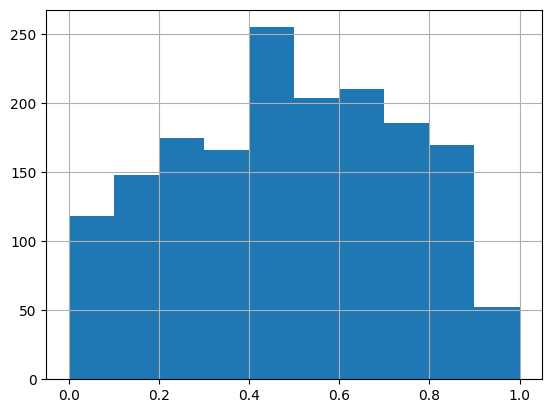

In [122]:
df[['ds', 'Plant-Generic','SMAPE']].set_index(['ds', 'Plant-Generic']).unstack().mean().hist()

<AxesSubplot:ylabel='Plant-Generic'>

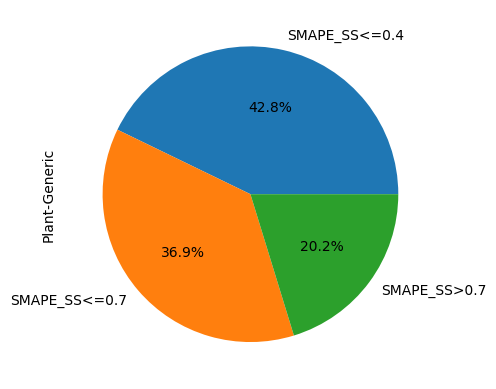

In [177]:
dg = df[['ds', 'Plant-Generic','SMAPE_SS']].set_index(['ds', 'Plant-Generic']).unstack().mean().reset_index()\
    .rename(columns={0:'SMAPE_SS'})
dg['segmentation'] = dg['SMAPE_SS'].apply(lambda x: 'SMAPE_SS<=0.4' if x<=0.4 else 'SMAPE_SS<=0.7' if x<=0.7 else 'SMAPE_SS>0.7')
dg.groupby('segmentation')['Plant-Generic'].count().plot.pie(autopct='%1.1f%%')

<AxesSubplot:xlabel='ds'>

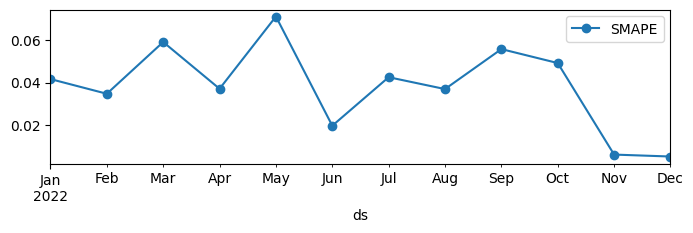

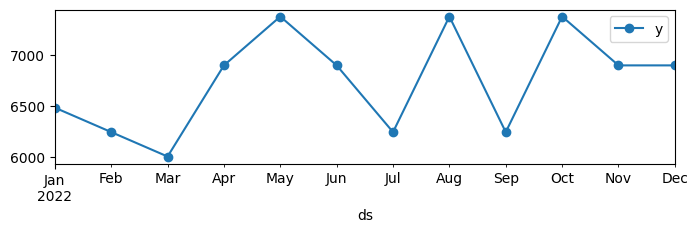

In [154]:
df[df['Plant-Generic']=='3841-24816'].plot.line(x='ds', y='SMAPE', marker='o',figsize=(8,2))
df[df['Plant-Generic']=='3841-24816'].plot.line(x='ds', y='y', marker='o',figsize=(8,2))

In [145]:
df.columns

Index(['ds', 'Plant-Generic', 'y', 'y-1', 'y-2', 'y-3', 'y-4', 'c', 'c-1', 'c-2', 'c-3', 'c-4', 'score (y-1)', 'score (y-2)', 'score (y-3)', 'score (y-4)', 'score (c-1)', 'score (c-2)', 'score (c-3)', 'score (c-4)', 'score', '4 Month Trend', 'MA', 'SMAPE', 'SMAPE_SS'], dtype='object')

In [155]:
df[df['Plant-Generic']=='3841-24816'][['ds','y','4 Month Trend','SMAPE']].T

/data/dataiku/dss_data/code-envs/python/py37/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1371: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.object


,55462,57146,58830,60514,62198,63882,65566,67250,68934,70618,72302,73986
ds,2022-01-01 00:00:00+00:00,2022-02-01 00:00:00+00:00,2022-03-01 00:00:00+00:00,2022-04-01 00:00:00+00:00,2022-05-01 00:00:00+00:00,2022-06-01 00:00:00+00:00,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00,2022-09-01 00:00:00+00:00,2022-10-01 00:00:00+00:00,2022-11-01 00:00:00+00:00,2022-12-01 00:00:00+00:00
y,6482,6241,6000,6899,7381,6899,6241,7381,6241,7381,6899,6899
4 Month Trend,FLAT,UP,UP,UP,FLAT,DOWN,FLAT,UP,FLAT,FLAT,FLAT,FLAT
SMAPE,0.0416028,0.0347601,0.0588789,0.0370927,0.0707576,0.0198644,0.0424793,0.0369486,0.0555745,0.0490708,0.00641867,0.00551371


Populating the interactive namespace from numpy and matplotlib


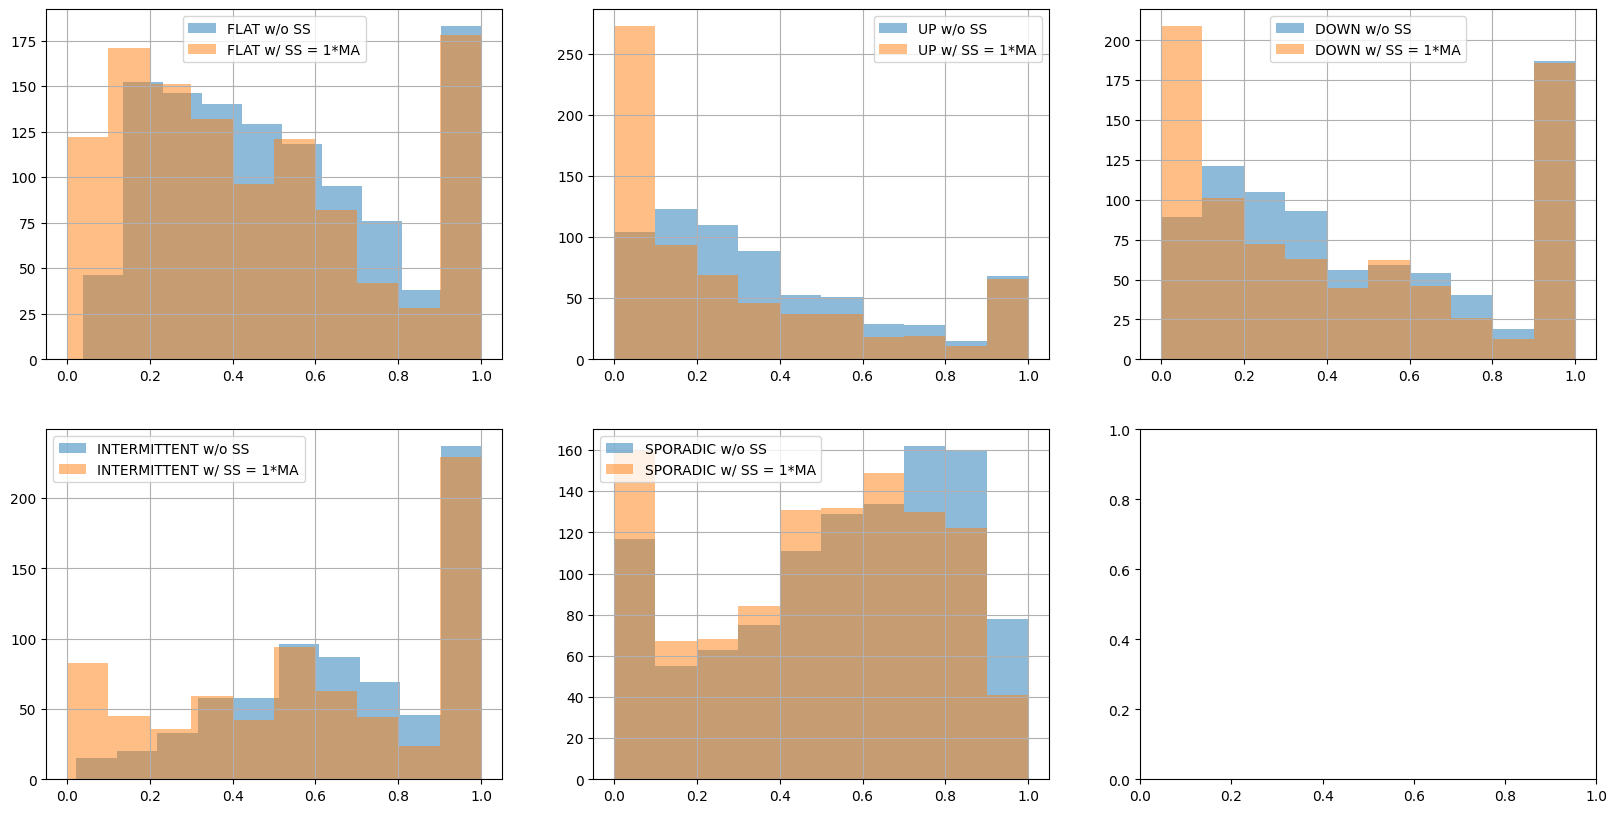

In [96]:
%pylab inline
def MA(flag,ax): #this is by 'Plant-Generic'
    ax = df[df['4 Month Trend']==flag].groupby(['Plant-Generic'])['SMAPE'].mean().hist(ax=ax,alpha=0.5, label=flag+' w/o SS')
    ax.legend()
    
def MA_SS(flag,ax): #this is by 'Plant-Generic'
    ax = df[df['4 Month Trend']==flag].groupby(['Plant-Generic'])['SMAPE_SS'].mean().hist(ax=ax,alpha=0.5, label=flag+' w/ SS = 1*MA')
    ax.legend()    
    
fig, axes = plt.subplots(2,3,figsize=(20,10))
flag = 'FLAT'; MA(flag,axes[0,0])
flag = 'UP'; MA(flag,axes[0,1])
flag = 'DOWN'; MA(flag,axes[0,2])
flag = 'INTERMITTENT'; MA(flag,axes[1,0])
flag = 'SPORADIC'; MA(flag,axes[1,1])

flag = 'FLAT'; MA_SS(flag,axes[0,0])
flag = 'UP'; MA_SS(flag,axes[0,1])
flag = 'DOWN'; MA_SS(flag,axes[0,2])
flag = 'INTERMITTENT'; MA_SS(flag,axes[1,0])
flag = 'SPORADIC'; MA_SS(flag,axes[1,1])
# def clustering(flag, df):
#     df['Plant'] = df['Plant-Generic'].apply(lambda x: x.split('-')[0])
#     df['Generic'] = df['Plant-Generic'].apply(lambda x: x.split('-')[0])
#     df = df[df['4 Month Trend']==flag]
#     df = df.groupby(['Generic','ds'])[['y', 'y-1', 'y-2', 'y-3', 'y-4']].sum()
#     df['MA'] = (df['y-1']+df['y-2']+df['y-3']+df['y-4'])/4.0
#     df['SMAPE'] = df.apply(lambda x: 0 if abs(x['y']+x['MA'])==0 else abs(x['y']-x['MA'])/abs(x['y']+x['MA'])*2, axis=1)
#     ax = df['SMAPE'].hist()
#     ax.set_title(flag)  

In [109]:
df.groupby(['Plant-Generic'])['4 Month Trend'].unique().reset_index().astype(str).groupby(['4 Month Trend'])['Plant-Generic'].unique()

4 Month Trend
['DOWN' 'FLAT' 'INTERMITTENT' 'SPORADIC' 'UP']                                         [3811-23523]
['DOWN' 'FLAT' 'INTERMITTENT' 'SPORADIC']                                  [3811-13410, 3811-16107]
['DOWN' 'FLAT' 'INTERMITTENT' 'UP']                                         [3803-1271, 3803-18111]
['DOWN' 'FLAT' 'INTERMITTENT']                       [3803-2321, 3803-4343, 3841-20524, 3841-20938]
['DOWN' 'FLAT' 'SPORADIC' 'INTERMITTENT']         [3803-2274, 3803-23845, 3811-14165, 3811-2128,...
['DOWN' 'FLAT' 'SPORADIC' 'UP']                                                        [3809-18171]
['DOWN' 'FLAT' 'SPORADIC']                                     [3809-23097, 3809-31470, 3811-25130]
['DOWN' 'FLAT' 'UP' 'INTERMITTENT' 'SPORADIC']     [3809-25131, 3811-24759, 3811-26375, 3833-10092]
['DOWN' 'FLAT' 'UP' 'INTERMITTENT']               [3803-1661, 3803-2789, 3809-13810, 3809-22415,...
['DOWN' 'FLAT' 'UP' 'SPORADIC' 'INTERMITTENT']                                        

In [98]:
df.columns

Index(['ds', 'Plant-Generic', 'y', 'y-1', 'y-2', 'y-3', 'y-4', 'c', 'c-1', 'c-2', 'c-3', 'c-4', 'score (y-1)', 'score (y-2)', 'score (y-3)', 'score (y-4)', 'score (c-1)', 'score (c-2)', 'score (c-3)', 'score (c-4)', 'score', '4 Month Trend', 'MA', 'SMAPE', 'SMAPE_SS'], dtype='object')